Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function

import os
import sys
import tarfile

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples (50k and 1.9k for each class). Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
display(Image(filename='./notMNIST_large/A/emlwZXJoZWFkLnR0Zg==.png'))
display(Image(filename='./notMNIST_large/A/a29ydW5pc2hpLnR0Zg==.png'))
display(Image(filename='./notMNIST_large/A/a2FkZW4udHRm.png'))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(
      shape=(len(image_files), image_size, image_size),
      dtype=np.float32
  )

  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      # ndimage.read read data as [0, 255], need to scale it to [-1, 1]
      image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)


./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

In [6]:
print(train_datasets)
print(test_datasets)

['./notMNIST_large/A.pickle', './notMNIST_large/B.pickle', './notMNIST_large/C.pickle', './notMNIST_large/D.pickle', './notMNIST_large/E.pickle', './notMNIST_large/F.pickle', './notMNIST_large/G.pickle', './notMNIST_large/H.pickle', './notMNIST_large/I.pickle', './notMNIST_large/J.pickle']
['./notMNIST_small/A.pickle', './notMNIST_small/B.pickle', './notMNIST_small/C.pickle', './notMNIST_small/D.pickle', './notMNIST_small/E.pickle', './notMNIST_small/F.pickle', './notMNIST_small/G.pickle', './notMNIST_small/H.pickle', './notMNIST_small/I.pickle', './notMNIST_small/J.pickle']


---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [7]:
with open(train_datasets[0], 'rb') as f:
    dataset_tmp = pickle.load(f)
dataset_tmp.shape

(52909, 28, 28)

In [8]:
image_tmp = dataset_tmp[0]
image_tmp.shape

(28, 28)

In [9]:
image_tmp

array([[-0.5       , -0.5       , -0.5       , -0.5       , -0.48431373,
        -0.5       , -0.19019608,  0.46862745,  0.49215686,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.49215686,
         0.46862745, -0.19019608, -0.5       , -0.48431373, -0.5       ,
        -0.5       , -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , -0.48823529, -0.5       ,
        -0.30392158,  0.43333334,  0.5       ,  0.49215686,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ,  0.5       ,  0.5       ,  0.5       ,  0.49215686,
         0.5       ,  0.43333334, -0.30392158, -0.5       , -0.48823529,
        -0.5       , -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.48823529, -0.5       , -0.37843138,
         0.38627452,  0.5       ,  0.49215686,  0.5       ,  0.5       ,
         0.5       ,  0.5   

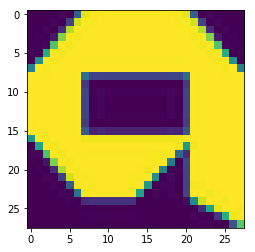

In [10]:
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib.pyplot.imshow
plt.imshow(image_tmp)

[[ 0.          0.          0.          0.          0.01568628  0.
   0.30980393  0.96862745  0.99215686  1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   0.99215686  0.96862745  0.30980393  0.          0.01568628  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.01176471  0.          0.19607843
   0.93333334  1.          0.99215686  1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   0.99215686  1.          0.93333334  0.19607843  0.          0.01176471
   0.          0.          0.        ]
 [ 0.          0.          0.01176471  0.          0.12156863  0.88627452
   1.          0.99215686  1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   0.99215686  1.          0.88627452  0.12156863  0.          0.01176471
   0.          0.        ]
 [ 0.          0.007843

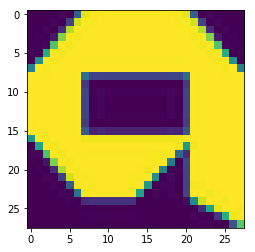

In [11]:
import matplotlib.image as mpimg
# matplotlib.image.imread get data as [0, 1]
img=mpimg.imread('./notMNIST_large/A/a29ydW5pc2hpLnR0Zg==.png')
print(img)
imgplot = plt.imshow(img)

In [12]:
display(Image(filename='./notMNIST_large/A/a29ydW5pc2hpLnR0Zg==.png'))

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [13]:
for dataset_file in train_datasets + test_datasets:
    with open(dataset_file, 'rb') as f:
        dataset_tmp = pickle.load(f)        
        print(dataset_file, dataset_tmp.shape)        

./notMNIST_large/A.pickle (52909, 28, 28)
./notMNIST_large/B.pickle (52911, 28, 28)
./notMNIST_large/C.pickle (52912, 28, 28)
./notMNIST_large/D.pickle (52911, 28, 28)
./notMNIST_large/E.pickle (52912, 28, 28)
./notMNIST_large/F.pickle (52912, 28, 28)
./notMNIST_large/G.pickle (52912, 28, 28)
./notMNIST_large/H.pickle (52912, 28, 28)
./notMNIST_large/I.pickle (52912, 28, 28)
./notMNIST_large/J.pickle (52911, 28, 28)
./notMNIST_small/A.pickle (1872, 28, 28)
./notMNIST_small/B.pickle (1873, 28, 28)
./notMNIST_small/C.pickle (1873, 28, 28)
./notMNIST_small/D.pickle (1873, 28, 28)
./notMNIST_small/E.pickle (1873, 28, 28)
./notMNIST_small/F.pickle (1872, 28, 28)
./notMNIST_small/G.pickle (1872, 28, 28)
./notMNIST_small/H.pickle (1872, 28, 28)
./notMNIST_small/I.pickle (1872, 28, 28)
./notMNIST_small/J.pickle (1872, 28, 28)


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [14]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes  # integer division
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class + tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
# can tune the sizes here
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [15]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

# avoid sequential training data, like all As, then all Bs, then all Cs, etc.
# That breaks the assumption that your data is taking random steps over time.
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [16]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


4

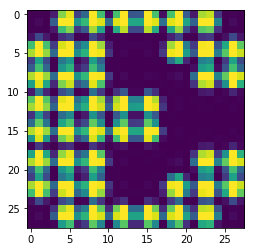

In [17]:
image_tmp = train_dataset[0]
plt.imshow(image_tmp)

train_labels[0]

Finally, let's save the data for later reuse:

In [18]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    

In [19]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)


Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [ ]:
1 in [1, 2]

In [45]:
a = np.array([[1,2], [3, 4]])
print(a)

b = np.array([[1,2], [3, 5]])
print(b)

print(np.array_equal(a,b))

[[1 2]
 [3 4]]
[[1 2]
 [3 5]]
False


In [25]:
np.array_equal([1,2], [1, 2])

True

In [28]:
np.allclose([1,2], [1, 2.0000], equal_nan=True)

True

In [39]:
# def check_duplicate(dataset1, dataset2):
#     dataset1_loop = 0
#     dataset2_loop = 0
#     dup_count = 0
    
#     for i in dataset1:
#         dataset1_loop += 1
#         if (dataset1_loop % 100) == 0:
#             print('dataset1_loop', dataset1_loop)
            
#         for j in dataset2:
#             dataset2_loop += 1
#             if np.array_equal(i, j):
#                 dup_count += 1
#                 print('dup', dup_count)

#     print(dataset1.shape, dataset2.shape, dup_count)

    
# check_duplicate(test_dataset, train_dataset)

dup 1
dup 2
dup 3
dup 4
dup 5
dup 6
dup 7
dup 8
dup 9
dup 10
dup 11
dup 12
dataset1_loop 100
dup 13
dup 14
dup 15
dup 16
dup 17
dup 18
dup 19
dup 20
dup 21
dup 22
dup 23
dup 24
dup 25
dup 26
dup 27
dup 28
dup 29
dup 30
dup 31
dup 32
dup 33
dup 34
dup 35
dup 36
dup 37
dup 38
dup 39
dup 40
dup 41
dup 42
dup 43
dup 44
dup 45
dup 46
dup 47
dup 48
dup 49
dup 50
dup 51
dup 52
dup 53
dup 54
dup 55
dup 56
dup 57
dup 58
dup 59
dup 60
dup 61
dup 62
dup 63
dup 64
dup 65
dup 66
dup 67
dup 68
dup 69
dup 70
dup 71
dup 72
dup 73
dup 74
dup 75
dup 76
dup 77
dup 78
dup 79
dup 80
dup 81
dup 82
dup 83
dup 84
dup 85
dup 86
dup 87
dup 88
dup 89
dup 90
dup 91
dup 92
dup 93
dup 94
dup 95
dup 96
dup 97
dup 98
dup 99
dup 100
dup 101
dup 102
dup 103
dup 104
dup 105
dup 106
dup 107
dup 108
dup 109
dup 110
dup 111
dup 112
dup 113
dup 114
dup 115
dup 116
dup 117
dup 118
dup 119
dup 120
dup 121
dup 122
dup 123
dup 124
dup 125
dup 126
dup 127
dup 128
dup 129
dup 130
dup 131
dup 132
dup 133
dup 134
dup 135
dup 136
du

dup 1115
dup 1116
dup 1117
dup 1118
dup 1119
dup 1120
dup 1121
dup 1122
dup 1123
dup 1124
dup 1125
dup 1126
dup 1127
dup 1128
dup 1129
dup 1130
dup 1131
dup 1132
dup 1133
dup 1134
dup 1135
dup 1136
dup 1137
dup 1138
dup 1139
dup 1140
dup 1141
dup 1142
dup 1143
dup 1144
dup 1145
dup 1146
dup 1147
dup 1148
dup 1149
dup 1150
dup 1151
dup 1152
dup 1153
dup 1154
dup 1155
dup 1156
dup 1157
dup 1158
dup 1159
dup 1160
dup 1161
dup 1162
dup 1163
dup 1164
dup 1165
dup 1166
dup 1167
dup 1168
dup 1169
dup 1170
dup 1171
dup 1172
dup 1173
dup 1174
dup 1175
dup 1176
dup 1177
dup 1178
dup 1179
dup 1180
dup 1181
dup 1182
dup 1183
dup 1184
dup 1185
dup 1186
dup 1187
dup 1188
dup 1189
dup 1190
dup 1191
dup 1192
dup 1193
dup 1194
dup 1195
dup 1196
dup 1197
dup 1198
dup 1199
dup 1200
dup 1201
dup 1202
dup 1203
dup 1204
dup 1205
dup 1206
dup 1207
dup 1208
dup 1209
dup 1210
dup 1211
dup 1212
dup 1213
dup 1214
dup 1215
dup 1216
dup 1217
dup 1218
dup 1219
dup 1220
dup 1221
dup 1222
dup 1223
dup 1224
dup 1225
d

dup 2117
dup 2118
dup 2119
dup 2120
dup 2121
dup 2122
dup 2123
dup 2124
dup 2125
dup 2126
dup 2127
dup 2128
dup 2129
dup 2130
dup 2131
dup 2132
dup 2133
dup 2134
dup 2135
dup 2136
dup 2137
dup 2138
dup 2139
dup 2140
dup 2141
dup 2142
dup 2143
dup 2144
dup 2145
dup 2146
dup 2147
dup 2148
dup 2149
dup 2150
dup 2151
dup 2152
dup 2153
dup 2154
dup 2155
dup 2156
dup 2157
dup 2158
dup 2159
dup 2160
dup 2161
dup 2162
dup 2163
dup 2164
dup 2165
dup 2166
dup 2167
dup 2168
dup 2169
dup 2170
dup 2171
dup 2172
dup 2173
dup 2174
dup 2175
dup 2176
dup 2177
dup 2178
dup 2179
dup 2180
dup 2181
dup 2182
dup 2183
dup 2184
dup 2185
dup 2186
dup 2187
dup 2188
dup 2189
dup 2190
dup 2191
dup 2192
dup 2193
dup 2194
dup 2195
dup 2196
dup 2197
dup 2198
dup 2199
dup 2200
dup 2201
dup 2202
dup 2203
dup 2204
dup 2205
dup 2206
dup 2207
dup 2208
dup 2209
dup 2210
dup 2211
dup 2212
dup 2213
dup 2214
dup 2215
dup 2216
dup 2217
dup 2218
dup 2219
dup 2220
dup 2221
dup 2222
dup 2223
dup 2224
dup 2225
dup 2226
dup 2227
d

dup 3131
dup 3132
dup 3133
dup 3134
dup 3135
dup 3136
dup 3137
dup 3138
dup 3139
dup 3140
dup 3141
dup 3142
dup 3143
dup 3144
dup 3145
dup 3146
dup 3147
dup 3148
dup 3149
dup 3150
dup 3151
dup 3152
dup 3153
dup 3154
dup 3155
dup 3156
dup 3157
dup 3158
dup 3159
dup 3160
dup 3161
dup 3162
dup 3163
dup 3164
dup 3165
dup 3166
dup 3167
dup 3168
dup 3169
dup 3170
dup 3171
dup 3172
dup 3173
dup 3174
dup 3175
dup 3176
dup 3177
dup 3178
dup 3179
dup 3180
dup 3181
dup 3182
dup 3183
dup 3184
dup 3185
dup 3186
dup 3187
dup 3188
dup 3189
dup 3190
dup 3191
dup 3192
dup 3193
dup 3194
dup 3195
dup 3196
dup 3197
dup 3198
dup 3199
dup 3200
dup 3201
dup 3202
dup 3203
dup 3204
dup 3205
dup 3206
dup 3207
dup 3208
dup 3209
dup 3210
dup 3211
dup 3212
dup 3213
dup 3214
dup 3215
dup 3216
dup 3217
dup 3218
dup 3219
dup 3220
dup 3221
dup 3222
dup 3223
dup 3224
dup 3225
dup 3226
dup 3227
dup 3228
dup 3229
dup 3230
dup 3231
dup 3232
dup 3233
dup 3234
dup 3235
dup 3236
dup 3237
dup 3238
dup 3239
dup 3240
dup 3241
d

dup 4217
dup 4218
dup 4219
dup 4220
dup 4221
dup 4222
dup 4223
dup 4224
dup 4225
dup 4226
dup 4227
dup 4228
dup 4229
dup 4230
dup 4231
dup 4232
dup 4233
dup 4234
dup 4235
dup 4236
dup 4237
dup 4238
dup 4239
dup 4240
dup 4241
dup 4242
dup 4243
dup 4244
dup 4245
dup 4246
dup 4247
dup 4248
dup 4249
dup 4250
dup 4251
dup 4252
dup 4253
dup 4254
dup 4255
dup 4256
dup 4257
dup 4258
dup 4259
dup 4260
dup 4261
dup 4262
dup 4263
dup 4264
dup 4265
dup 4266
dup 4267
dup 4268
dup 4269
dup 4270
dup 4271
dup 4272
dup 4273
dup 4274
dup 4275
dup 4276
dup 4277
dup 4278
dup 4279
dup 4280
dup 4281
dup 4282
dup 4283
dup 4284
dup 4285
dup 4286
dup 4287
dup 4288
dup 4289
dup 4290
dup 4291
dup 4292
dup 4293
dup 4294
dup 4295
dup 4296
dup 4297
dup 4298
dup 4299
dup 4300
dup 4301
dup 4302
dup 4303
dup 4304
dup 4305
dup 4306
dup 4307
dup 4308
dup 4309
dup 4310
dup 4311
dup 4312
dup 4313
dup 4314
dup 4315
dup 4316
dup 4317
dup 4318
dup 4319
dup 4320
dup 4321
dup 4322
dup 4323
dup 4324
dup 4325
dup 4326
dup 4327
d

dup 5237
dup 5238
dup 5239
dup 5240
dup 5241
dup 5242
dup 5243
dup 5244
dup 5245
dup 5246
dup 5247
dup 5248
dup 5249
dup 5250
dup 5251
dup 5252
dup 5253
dup 5254
dup 5255
dup 5256
dup 5257
dup 5258
dup 5259
dup 5260
dup 5261
dup 5262
dup 5263
dup 5264
dup 5265
dup 5266
dup 5267
dup 5268
dup 5269
dup 5270
dup 5271
dup 5272
dup 5273
dup 5274
dup 5275
dup 5276
dup 5277
dup 5278
dup 5279
dup 5280
dup 5281
dup 5282
dup 5283
dup 5284
dup 5285
dup 5286
dup 5287
dup 5288
dup 5289
dup 5290
dup 5291
dup 5292
dup 5293
dup 5294
dup 5295
dup 5296
dup 5297
dup 5298
dup 5299
dup 5300
dup 5301
dup 5302
dup 5303
dup 5304
dup 5305
dup 5306
dup 5307
dup 5308
dup 5309
dup 5310
dup 5311
dup 5312
dup 5313
dup 5314
dup 5315
dup 5316
dup 5317
dup 5318
dup 5319
dup 5320
dup 5321
dup 5322
dup 5323
dup 5324
dup 5325
dup 5326
dup 5327
dup 5328
dup 5329
dup 5330
dup 5331
dup 5332
dup 5333
dup 5334
dup 5335
dup 5336
dup 5337
dup 5338
dup 5339
dup 5340
dup 5341
dup 5342
dup 5343
dup 5344
dup 5345
dup 5346
dup 5347
d

dup 6262
dup 6263
dup 6264
dup 6265
dup 6266
dup 6267
dup 6268
dup 6269
dup 6270
dup 6271
dup 6272
dup 6273
dup 6274
dup 6275
dup 6276
dup 6277
dup 6278
dup 6279
dup 6280
dup 6281
dup 6282
dup 6283
dup 6284
dup 6285
dup 6286
dup 6287
dup 6288
dup 6289
dup 6290
dup 6291
dup 6292
dup 6293
dup 6294
dup 6295
dup 6296
dup 6297
dup 6298
dup 6299
dup 6300
dup 6301
dup 6302
dup 6303
dup 6304
dup 6305
dup 6306
dup 6307
dup 6308
dup 6309
dup 6310
dup 6311
dup 6312
dup 6313
dup 6314
dup 6315
dup 6316
dup 6317
dup 6318
dup 6319
dup 6320
dup 6321
dup 6322
dup 6323
dup 6324
dup 6325
dup 6326
dup 6327
dup 6328
dup 6329
dup 6330
dup 6331
dup 6332
dup 6333
dup 6334
dup 6335
dup 6336
dup 6337
dup 6338
dup 6339
dup 6340
dup 6341
dup 6342
dup 6343
dup 6344
dup 6345
dup 6346
dup 6347
dup 6348
dup 6349
dup 6350
dup 6351
dup 6352
dup 6353
dup 6354
dup 6355
dup 6356
dup 6357
dup 6358
dup 6359
dup 6360
dup 6361
dup 6362
dup 6363
dup 6364
dup 6365
dup 6366
dup 6367
dup 6368
dup 6369
dup 6370
dup 6371
dup 6372
d

dup 7220
dup 7221
dup 7222
dup 7223
dup 7224
dup 7225
dup 7226
dup 7227
dup 7228
dup 7229
dup 7230
dup 7231
dup 7232
dup 7233
dup 7234
dup 7235
dup 7236
dup 7237
dup 7238
dup 7239
dup 7240
dup 7241
dup 7242
dup 7243
dup 7244
dup 7245
dup 7246
dup 7247
dup 7248
dup 7249
dup 7250
dup 7251
dup 7252
dup 7253
dup 7254
dup 7255
dup 7256
dup 7257
dup 7258
dup 7259
dup 7260
dup 7261
dup 7262
dup 7263
dup 7264
dup 7265
dup 7266
dup 7267
dup 7268
dup 7269
dup 7270
dup 7271
dup 7272
dup 7273
dup 7274
dup 7275
dup 7276
dup 7277
dup 7278
dup 7279
dup 7280
dup 7281
dup 7282
dup 7283
dup 7284
dup 7285
dup 7286
dup 7287
dup 7288
dup 7289
dup 7290
dup 7291
dup 7292
dup 7293
dup 7294
dup 7295
dup 7296
dup 7297
dup 7298
dup 7299
dup 7300
dup 7301
dup 7302
dup 7303
dup 7304
dup 7305
dup 7306
dup 7307
dup 7308
dup 7309
dup 7310
dup 7311
dup 7312
dup 7313
dup 7314
dup 7315
dup 7316
dup 7317
dup 7318
dup 7319
dup 7320
dup 7321
dup 7322
dup 7323
dup 7324
dup 7325
dup 7326
dup 7327
dup 7328
dup 7329
dup 7330
d

dup 8245
dup 8246
dup 8247
dup 8248
dup 8249
dup 8250
dup 8251
dup 8252
dup 8253
dup 8254
dup 8255
dup 8256
dup 8257
dup 8258
dup 8259
dup 8260
dup 8261
dup 8262
dup 8263
dup 8264
dup 8265
dup 8266
dup 8267
dup 8268
dup 8269
dup 8270
dup 8271
dup 8272
dup 8273
dup 8274
dup 8275
dup 8276
dup 8277
dup 8278
dup 8279
dup 8280
dup 8281
dup 8282
dup 8283
dup 8284
dup 8285
dup 8286
dup 8287
dup 8288
dup 8289
dup 8290
dup 8291
dup 8292
dup 8293
dup 8294
dup 8295
dup 8296
dup 8297
dup 8298
dup 8299
dup 8300
dup 8301
dup 8302
dup 8303
dup 8304
dup 8305
dup 8306
dup 8307
dup 8308
dup 8309
dup 8310
dup 8311
dup 8312
dup 8313
dup 8314
dup 8315
dup 8316
dup 8317
dup 8318
dup 8319
dup 8320
dup 8321
dup 8322
dup 8323
dup 8324
dup 8325
dup 8326
dup 8327
dup 8328
dup 8329
dup 8330
dup 8331
dup 8332
dup 8333
dup 8334
dup 8335
dup 8336
dup 8337
dup 8338
dup 8339
dup 8340
dup 8341
dup 8342
dup 8343
dup 8344
dup 8345
dup 8346
dup 8347
dup 8348
dup 8349
dup 8350
dup 8351
dup 8352
dup 8353
dup 8354
dup 8355
d

dup 9226
dup 9227
dup 9228
dup 9229
dup 9230
dup 9231
dup 9232
dup 9233
dup 9234
dup 9235
dup 9236
dup 9237
dup 9238
dup 9239
dup 9240
dup 9241
dup 9242
dup 9243
dup 9244
dup 9245
dup 9246
dup 9247
dup 9248
dup 9249
dup 9250
dup 9251
dup 9252
dup 9253
dup 9254
dup 9255
dup 9256
dup 9257
dup 9258
dup 9259
dup 9260
dup 9261
dup 9262
dup 9263
dup 9264
dup 9265
dup 9266
dup 9267
dup 9268
dup 9269
dup 9270
dup 9271
dup 9272
dup 9273
dup 9274
dup 9275
dup 9276
dup 9277
dup 9278
dup 9279
dup 9280
dup 9281
dup 9282
dup 9283
dup 9284
dup 9285
dup 9286
dup 9287
dup 9288
dup 9289
dup 9290
dup 9291
dup 9292
dup 9293
dup 9294
dup 9295
dup 9296
dup 9297
dup 9298
dup 9299
dup 9300
dup 9301
dup 9302
dup 9303
dup 9304
dup 9305
dup 9306
dup 9307
dup 9308
dup 9309
dup 9310
dup 9311
dup 9312
dup 9313
dup 9314
dup 9315
dup 9316
dup 9317
dup 9318
dup 9319
dup 9320
dup 9321
dup 9322
dup 9323
dup 9324
dup 9325
dup 9326
dup 9327
dup 9328
dup 9329
dup 9330
dup 9331
dup 9332
dup 9333
dup 9334
dup 9335
dup 9336
d

dup 10220
dup 10221
dup 10222
dup 10223
dup 10224
dup 10225
dup 10226
dup 10227
dup 10228
dup 10229
dup 10230
dup 10231
dup 10232
dup 10233
dup 10234
dup 10235
dup 10236
dup 10237
dup 10238
dup 10239
dup 10240
dup 10241
dup 10242
dup 10243
dup 10244
dup 10245
dup 10246
dup 10247
dup 10248
dup 10249
dup 10250
dup 10251
dup 10252
dup 10253
dup 10254
dup 10255
dup 10256
dup 10257
dup 10258
dup 10259
dup 10260
dup 10261
dup 10262
dup 10263
dup 10264
dup 10265
dup 10266
dup 10267
dup 10268
dup 10269
dup 10270
dup 10271
dup 10272
dup 10273
dup 10274
dup 10275
dup 10276
dup 10277
dup 10278
dup 10279
dup 10280
dup 10281
dup 10282
dup 10283
dup 10284
dup 10285
dup 10286
dup 10287
dup 10288
dup 10289
dup 10290
dup 10291
dup 10292
dup 10293
dup 10294
dup 10295
dup 10296
dup 10297
dup 10298
dup 10299
dup 10300
dup 10301
dup 10302
dup 10303
dup 10304
dup 10305
dup 10306
dup 10307
dup 10308
dup 10309
dup 10310
dup 10311
dup 10312
dup 10313
dup 10314
dup 10315
dup 10316
dup 10317
dup 10318
dup 10319


dup 11138
dup 11139
dup 11140
dup 11141
dup 11142
dup 11143
dup 11144
dup 11145
dup 11146
dup 11147
dup 11148
dup 11149
dup 11150
dup 11151
dup 11152
dup 11153
dup 11154
dup 11155
dup 11156
dup 11157
dup 11158
dup 11159
dup 11160
dup 11161
dup 11162
dup 11163
dup 11164
dup 11165
dup 11166
dup 11167
dup 11168
dup 11169
dup 11170
dup 11171
dup 11172
dup 11173
dup 11174
dup 11175
dup 11176
dup 11177
dup 11178
dup 11179
dup 11180
dup 11181
dup 11182
dup 11183
dup 11184
dup 11185
dup 11186
dup 11187
dup 11188
dup 11189
dup 11190
dup 11191
dup 11192
dup 11193
dup 11194
dup 11195
dup 11196
dup 11197
dup 11198
dup 11199
dup 11200
dup 11201
dup 11202
dup 11203
dup 11204
dup 11205
dup 11206
dup 11207
dup 11208
dup 11209
dup 11210
dup 11211
dup 11212
dup 11213
dup 11214
dup 11215
dup 11216
dup 11217
dup 11218
dup 11219
dup 11220
dup 11221
dup 11222
dup 11223
dup 11224
dup 11225
dup 11226
dup 11227
dup 11228
dup 11229
dup 11230
dup 11231
dup 11232
dup 11233
dup 11234
dup 11235
dup 11236
dup 11237


dup 11993
dup 11994
dup 11995
dup 11996
dup 11997
dup 11998
dup 11999
dup 12000
dup 12001
dup 12002
dup 12003
dup 12004
dup 12005
dup 12006
dup 12007
dup 12008
dup 12009
dup 12010
dup 12011
dup 12012
dup 12013
dup 12014
dup 12015
dup 12016
dup 12017
dup 12018
dup 12019
dup 12020
dup 12021
dup 12022
dup 12023
dup 12024
dup 12025
dup 12026
dup 12027
dup 12028
dup 12029
dup 12030
dup 12031
dup 12032
dup 12033
dup 12034
dup 12035
dup 12036
dup 12037
dup 12038
dup 12039
dup 12040
dup 12041
dup 12042
dup 12043
dup 12044
dup 12045
dup 12046
dup 12047
dup 12048
dup 12049
dup 12050
dup 12051
dup 12052
dup 12053
dup 12054
dup 12055
dup 12056
dup 12057
dup 12058
dup 12059
dup 12060
dup 12061
dup 12062
dup 12063
dup 12064
dup 12065
dup 12066
dup 12067
dup 12068
dup 12069
dup 12070
dup 12071
dup 12072
dup 12073
dup 12074
dup 12075
dup 12076
dup 12077
dup 12078
dup 12079
dup 12080
dup 12081
dup 12082
dup 12083
dup 12084
dup 12085
dup 12086
dup 12087
dup 12088
dup 12089
dup 12090
dup 12091
dup 12092


dup 12824
dup 12825
dup 12826
dup 12827
dup 12828
dup 12829
dup 12830
dup 12831
dup 12832
dup 12833
dup 12834
dup 12835
dup 12836
dup 12837
dup 12838
dup 12839
dup 12840
dup 12841
dup 12842
dup 12843
dup 12844
dup 12845
dup 12846
dup 12847
dup 12848
dup 12849
dup 12850
dup 12851
dup 12852
dup 12853
dup 12854
dup 12855
dup 12856
dup 12857
dup 12858
dup 12859
dup 12860
dup 12861
dup 12862
dup 12863
dup 12864
dup 12865
dup 12866
dup 12867
dup 12868
dup 12869
dup 12870
dup 12871
dup 12872
dup 12873
dup 12874
dup 12875
dup 12876
dup 12877
dup 12878
dup 12879
dup 12880
dup 12881
dup 12882
dup 12883
dup 12884
dup 12885
dup 12886
dup 12887
dup 12888
dup 12889
dup 12890
dup 12891
dup 12892
dup 12893
dup 12894
dup 12895
dup 12896
dup 12897
dup 12898
dup 12899
dup 12900
dup 12901
dup 12902
dup 12903
dup 12904
dup 12905
dup 12906
dup 12907
dup 12908
dup 12909
dup 12910
dup 12911
dup 12912
dup 12913
dup 12914
dup 12915
dup 12916
dup 12917
dup 12918
dup 12919
dup 12920
dup 12921
dup 12922
dup 12923


dup 13706
dup 13707
dup 13708
dup 13709
dup 13710
dup 13711
dup 13712
dup 13713
dup 13714
dup 13715
dup 13716
dup 13717
dup 13718
dup 13719
dup 13720
dup 13721
dup 13722
dup 13723
dup 13724
dup 13725
dup 13726
dup 13727
dup 13728
dup 13729
dup 13730
dup 13731
dup 13732
dup 13733
dup 13734
dup 13735
dup 13736
dup 13737
dup 13738
dup 13739
dup 13740
dup 13741
dup 13742
dup 13743
dup 13744
dup 13745
dup 13746
dup 13747
dup 13748
dup 13749
dup 13750
dup 13751
dup 13752
dup 13753
dup 13754
dup 13755
dup 13756
dup 13757
dup 13758
dup 13759
dup 13760
dup 13761
dup 13762
dup 13763
dup 13764
dup 13765
dup 13766
dup 13767
dup 13768
dup 13769
dup 13770
dup 13771
dup 13772
dup 13773
dup 13774
dup 13775
dup 13776
dup 13777
dup 13778
dup 13779
dup 13780
dup 13781
dup 13782
dup 13783
dup 13784
dup 13785
dup 13786
dup 13787
dup 13788
dup 13789
dup 13790
dup 13791
dup 13792
dup 13793
dup 13794
dup 13795
dup 13796
dup 13797
dup 13798
dup 13799
dup 13800
dup 13801
dup 13802
dup 13803
dup 13804
dup 13805


dup 14721
dup 14722
dup 14723
dup 14724
dup 14725
dup 14726
dup 14727
dup 14728
dup 14729
dup 14730
dup 14731
dup 14732
dup 14733
dup 14734
dup 14735
dup 14736
dup 14737
dup 14738
dup 14739
dup 14740
dup 14741
dup 14742
dup 14743
dup 14744
dup 14745
dup 14746
dup 14747
dup 14748
dup 14749
dup 14750
dup 14751
dup 14752
dup 14753
dup 14754
dup 14755
dup 14756
dup 14757
dup 14758
dup 14759
dup 14760
dup 14761
dup 14762
dup 14763
dup 14764
dup 14765
dup 14766
dup 14767
dup 14768
dup 14769
dup 14770
dup 14771
dup 14772
dup 14773
dup 14774
dup 14775
dup 14776
dup 14777
dup 14778
dup 14779
dup 14780
dup 14781
dup 14782
dup 14783
dup 14784
dup 14785
dup 14786
dup 14787
dup 14788
dup 14789
dup 14790
dup 14791
dup 14792
dup 14793
dup 14794
dup 14795
dup 14796
dup 14797
dup 14798
dup 14799
dup 14800
dup 14801
dup 14802
dup 14803
dup 14804
dup 14805
dup 14806
dup 14807
dup 14808
dup 14809
dup 14810
dup 14811
dup 14812
dup 14813
dup 14814
dup 14815
dup 14816
dup 14817
dup 14818
dup 14819
dup 14820


dup 15696
dup 15697
dup 15698
dup 15699
dup 15700
dup 15701
dup 15702
dup 15703
dup 15704
dup 15705
dup 15706
dup 15707
dup 15708
dup 15709
dup 15710
dup 15711
dup 15712
dup 15713
dup 15714
dup 15715
dup 15716
dup 15717
dup 15718
dup 15719
dup 15720
dup 15721
dup 15722
dup 15723
dup 15724
dup 15725
dup 15726
dup 15727
dup 15728
dup 15729
dup 15730
dup 15731
dup 15732
dup 15733
dup 15734
dup 15735
dup 15736
dup 15737
dup 15738
dup 15739
dup 15740
dup 15741
dup 15742
dup 15743
dup 15744
dup 15745
dup 15746
dup 15747
dup 15748
dup 15749
dup 15750
dup 15751
dup 15752
dup 15753
dup 15754
dup 15755
dup 15756
dup 15757
dup 15758
dup 15759
dup 15760
dup 15761
dup 15762
dup 15763
dup 15764
dup 15765
dup 15766
dup 15767
dup 15768
dup 15769
dup 15770
dup 15771
dup 15772
dup 15773
dup 15774
dup 15775
dup 15776
dup 15777
dup 15778
dup 15779
dup 15780
dup 15781
dup 15782
dup 15783
dup 15784
dup 15785
dup 15786
dup 15787
dup 15788
dup 15789
dup 15790
dup 15791
dup 15792
dup 15793
dup 15794
dup 15795


dup 16626
dup 16627
dup 16628
dup 16629
dup 16630
dup 16631
dup 16632
dup 16633
dup 16634
dup 16635
dup 16636
dup 16637
dup 16638
dup 16639
dup 16640
dup 16641
dup 16642
dup 16643
dup 16644
dup 16645
dup 16646
dup 16647
dup 16648
dup 16649
dup 16650
dup 16651
dup 16652
dup 16653
dup 16654
dup 16655
dup 16656
dup 16657
dup 16658
dup 16659
dup 16660
dup 16661
dup 16662
dup 16663
dup 16664
dup 16665
dup 16666
dup 16667
dup 16668
dup 16669
dup 16670
dup 16671
dup 16672
dup 16673
dup 16674
dup 16675
dup 16676
dup 16677
dup 16678
dup 16679
dup 16680
dup 16681
dup 16682
dup 16683
dup 16684
dup 16685
dup 16686
dup 16687
dup 16688
dup 16689
dup 16690
dup 16691
dup 16692
dup 16693
dup 16694
dup 16695
dup 16696
dup 16697
dup 16698
dup 16699
dup 16700
dup 16701
dup 16702
dup 16703
dup 16704
dup 16705
dup 16706
dup 16707
dup 16708
dup 16709
dup 16710
dup 16711
dup 16712
dup 16713
dup 16714
dup 16715
dup 16716
dup 16717
dup 16718
dup 16719
dup 16720
dup 16721
dup 16722
dup 16723
dup 16724
dup 16725


dup 17530
dup 17531
dup 17532
dup 17533
dataset1_loop 700
dup 17534
dup 17535
dup 17536
dup 17537
dup 17538
dup 17539
dup 17540
dup 17541
dup 17542
dup 17543
dup 17544
dup 17545
dup 17546
dup 17547
dup 17548
dup 17549
dup 17550
dup 17551
dup 17552
dup 17553
dup 17554
dup 17555
dup 17556
dup 17557
dup 17558
dup 17559
dup 17560
dup 17561
dup 17562
dup 17563
dup 17564
dup 17565
dup 17566
dup 17567
dup 17568
dup 17569
dup 17570
dup 17571
dup 17572
dup 17573
dup 17574
dup 17575
dup 17576
dup 17577
dup 17578
dup 17579
dup 17580
dup 17581
dup 17582
dup 17583
dup 17584
dup 17585
dup 17586
dup 17587
dup 17588
dup 17589
dup 17590
dup 17591
dup 17592
dup 17593
dup 17594
dup 17595
dup 17596
dup 17597
dup 17598
dup 17599
dup 17600
dup 17601
dup 17602
dup 17603
dup 17604
dup 17605
dup 17606
dup 17607
dup 17608
dup 17609
dup 17610
dup 17611
dup 17612
dup 17613
dup 17614
dup 17615
dup 17616
dup 17617
dup 17618
dup 17619
dup 17620
dup 17621
dup 17622
dup 17623
dup 17624
dup 17625
dup 17626
dup 17627
du

dup 18356
dup 18357
dup 18358
dup 18359
dup 18360
dup 18361
dup 18362
dup 18363
dup 18364
dup 18365
dup 18366
dup 18367
dup 18368
dup 18369
dup 18370
dup 18371
dup 18372
dup 18373
dup 18374
dup 18375
dup 18376
dup 18377
dup 18378
dup 18379
dup 18380
dup 18381
dup 18382
dup 18383
dup 18384
dup 18385
dup 18386
dup 18387
dup 18388
dup 18389
dup 18390
dup 18391
dup 18392
dup 18393
dup 18394
dup 18395
dup 18396
dup 18397
dup 18398
dup 18399
dup 18400
dup 18401
dup 18402
dup 18403
dup 18404
dup 18405
dup 18406
dup 18407
dup 18408
dup 18409
dup 18410
dup 18411
dup 18412
dup 18413
dup 18414
dup 18415
dup 18416
dup 18417
dup 18418
dup 18419
dup 18420
dup 18421
dup 18422
dup 18423
dup 18424
dup 18425
dup 18426
dup 18427
dup 18428
dup 18429
dup 18430
dup 18431
dup 18432
dup 18433
dup 18434
dup 18435
dup 18436
dup 18437
dup 18438
dup 18439
dup 18440
dup 18441
dup 18442
dup 18443
dup 18444
dup 18445
dup 18446
dup 18447
dup 18448
dup 18449
dup 18450
dup 18451
dup 18452
dup 18453
dup 18454
dup 18455


dup 19327
dup 19328
dup 19329
dup 19330
dup 19331
dup 19332
dup 19333
dup 19334
dup 19335
dup 19336
dup 19337
dup 19338
dup 19339
dup 19340
dup 19341
dup 19342
dup 19343
dup 19344
dup 19345
dup 19346
dup 19347
dup 19348
dup 19349
dup 19350
dup 19351
dup 19352
dup 19353
dup 19354
dup 19355
dup 19356
dup 19357
dup 19358
dup 19359
dup 19360
dup 19361
dup 19362
dup 19363
dup 19364
dup 19365
dup 19366
dup 19367
dup 19368
dup 19369
dup 19370
dup 19371
dup 19372
dup 19373
dup 19374
dup 19375
dup 19376
dup 19377
dup 19378
dup 19379
dup 19380
dup 19381
dup 19382
dup 19383
dup 19384
dup 19385
dup 19386
dup 19387
dup 19388
dup 19389
dup 19390
dup 19391
dup 19392
dup 19393
dup 19394
dup 19395
dup 19396
dup 19397
dup 19398
dup 19399
dup 19400
dup 19401
dup 19402
dup 19403
dup 19404
dup 19405
dup 19406
dup 19407
dup 19408
dup 19409
dup 19410
dup 19411
dup 19412
dup 19413
dup 19414
dup 19415
dup 19416
dup 19417
dup 19418
dup 19419
dup 19420
dup 19421
dup 19422
dup 19423
dup 19424
dup 19425
dup 19426


dup 20228
dup 20229
dup 20230
dup 20231
dup 20232
dup 20233
dup 20234
dup 20235
dup 20236
dup 20237
dup 20238
dup 20239
dup 20240
dup 20241
dup 20242
dup 20243
dup 20244
dup 20245
dup 20246
dup 20247
dup 20248
dup 20249
dup 20250
dup 20251
dup 20252
dup 20253
dup 20254
dup 20255
dup 20256
dup 20257
dup 20258
dup 20259
dup 20260
dup 20261
dup 20262
dup 20263
dup 20264
dup 20265
dup 20266
dup 20267
dup 20268
dup 20269
dup 20270
dup 20271
dup 20272
dup 20273
dup 20274
dup 20275
dup 20276
dup 20277
dup 20278
dup 20279
dup 20280
dup 20281
dup 20282
dup 20283
dup 20284
dup 20285
dup 20286
dup 20287
dup 20288
dup 20289
dup 20290
dup 20291
dup 20292
dup 20293
dup 20294
dup 20295
dup 20296
dup 20297
dup 20298
dup 20299
dup 20300
dup 20301
dup 20302
dup 20303
dup 20304
dup 20305
dup 20306
dup 20307
dup 20308
dup 20309
dup 20310
dup 20311
dup 20312
dup 20313
dup 20314
dup 20315
dup 20316
dup 20317
dup 20318
dup 20319
dup 20320
dup 20321
dup 20322
dup 20323
dup 20324
dup 20325
dup 20326
dup 20327


dup 21316
dup 21317
dup 21318
dup 21319
dup 21320
dup 21321
dup 21322
dup 21323
dup 21324
dup 21325
dup 21326
dup 21327
dup 21328
dup 21329
dup 21330
dup 21331
dup 21332
dup 21333
dup 21334
dup 21335
dup 21336
dup 21337
dup 21338
dup 21339
dup 21340
dup 21341
dup 21342
dup 21343
dup 21344
dup 21345
dup 21346
dup 21347
dup 21348
dup 21349
dup 21350
dup 21351
dup 21352
dup 21353
dup 21354
dup 21355
dup 21356
dup 21357
dup 21358
dup 21359
dup 21360
dup 21361
dup 21362
dup 21363
dup 21364
dup 21365
dup 21366
dup 21367
dup 21368
dup 21369
dup 21370
dup 21371
dup 21372
dup 21373
dup 21374
dup 21375
dup 21376
dup 21377
dup 21378
dup 21379
dup 21380
dup 21381
dup 21382
dup 21383
dup 21384
dup 21385
dup 21386
dup 21387
dup 21388
dup 21389
dup 21390
dup 21391
dup 21392
dup 21393
dup 21394
dup 21395
dup 21396
dup 21397
dup 21398
dup 21399
dup 21400
dup 21401
dup 21402
dup 21403
dup 21404
dup 21405
dup 21406
dup 21407
dup 21408
dup 21409
dup 21410
dup 21411
dup 21412
dup 21413
dup 21414
dup 21415


dup 22219
dup 22220
dup 22221
dup 22222
dup 22223
dup 22224
dup 22225
dup 22226
dup 22227
dup 22228
dup 22229
dup 22230
dup 22231
dup 22232
dup 22233
dup 22234
dup 22235
dup 22236
dup 22237
dup 22238
dup 22239
dup 22240
dup 22241
dup 22242
dup 22243
dup 22244
dup 22245
dup 22246
dup 22247
dup 22248
dup 22249
dup 22250
dup 22251
dup 22252
dup 22253
dup 22254
dup 22255
dup 22256
dup 22257
dup 22258
dup 22259
dup 22260
dup 22261
dup 22262
dup 22263
dup 22264
dup 22265
dup 22266
dup 22267
dup 22268
dup 22269
dup 22270
dup 22271
dup 22272
dup 22273
dup 22274
dup 22275
dup 22276
dup 22277
dup 22278
dup 22279
dup 22280
dup 22281
dup 22282
dup 22283
dup 22284
dup 22285
dup 22286
dup 22287
dup 22288
dup 22289
dup 22290
dup 22291
dup 22292
dup 22293
dup 22294
dup 22295
dup 22296
dup 22297
dup 22298
dup 22299
dup 22300
dup 22301
dup 22302
dup 22303
dup 22304
dup 22305
dup 22306
dup 22307
dup 22308
dup 22309
dup 22310
dup 22311
dup 22312
dup 22313
dup 22314
dup 22315
dup 22316
dup 22317
dup 22318


dup 23142
dup 23143
dup 23144
dup 23145
dup 23146
dup 23147
dup 23148
dup 23149
dup 23150
dup 23151
dup 23152
dup 23153
dup 23154
dup 23155
dup 23156
dup 23157
dup 23158
dup 23159
dup 23160
dup 23161
dup 23162
dup 23163
dup 23164
dup 23165
dup 23166
dup 23167
dup 23168
dup 23169
dup 23170
dup 23171
dup 23172
dup 23173
dup 23174
dup 23175
dup 23176
dup 23177
dup 23178
dup 23179
dup 23180
dup 23181
dup 23182
dup 23183
dup 23184
dup 23185
dup 23186
dup 23187
dup 23188
dup 23189
dup 23190
dup 23191
dup 23192
dup 23193
dup 23194
dup 23195
dup 23196
dup 23197
dup 23198
dup 23199
dup 23200
dup 23201
dup 23202
dup 23203
dup 23204
dup 23205
dup 23206
dup 23207
dup 23208
dup 23209
dup 23210
dup 23211
dup 23212
dup 23213
dup 23214
dup 23215
dup 23216
dup 23217
dup 23218
dup 23219
dup 23220
dup 23221
dup 23222
dup 23223
dup 23224
dup 23225
dup 23226
dup 23227
dup 23228
dup 23229
dup 23230
dup 23231
dup 23232
dup 23233
dup 23234
dup 23235
dup 23236
dup 23237
dup 23238
dup 23239
dup 23240
dup 23241


dup 23973
dup 23974
dup 23975
dup 23976
dup 23977
dup 23978
dup 23979
dup 23980
dup 23981
dup 23982
dup 23983
dup 23984
dup 23985
dup 23986
dup 23987
dup 23988
dup 23989
dup 23990
dup 23991
dup 23992
dup 23993
dup 23994
dup 23995
dup 23996
dup 23997
dup 23998
dup 23999
dup 24000
dup 24001
dup 24002
dup 24003
dup 24004
dup 24005
dup 24006
dup 24007
dup 24008
dup 24009
dup 24010
dup 24011
dup 24012
dup 24013
dup 24014
dup 24015
dup 24016
dup 24017
dup 24018
dup 24019
dup 24020
dup 24021
dup 24022
dup 24023
dup 24024
dup 24025
dup 24026
dup 24027
dup 24028
dup 24029
dup 24030
dup 24031
dup 24032
dup 24033
dup 24034
dup 24035
dup 24036
dup 24037
dup 24038
dup 24039
dup 24040
dup 24041
dup 24042
dup 24043
dup 24044
dup 24045
dup 24046
dup 24047
dup 24048
dup 24049
dup 24050
dup 24051
dup 24052
dup 24053
dup 24054
dup 24055
dup 24056
dup 24057
dup 24058
dup 24059
dup 24060
dup 24061
dup 24062
dup 24063
dup 24064
dup 24065
dup 24066
dup 24067
dup 24068
dup 24069
dup 24070
dup 24071
dup 24072


dup 24894
dup 24895
dup 24896
dup 24897
dup 24898
dup 24899
dup 24900
dup 24901
dup 24902
dup 24903
dup 24904
dup 24905
dup 24906
dup 24907
dup 24908
dup 24909
dup 24910
dup 24911
dup 24912
dup 24913
dup 24914
dup 24915
dup 24916
dup 24917
dup 24918
dup 24919
dup 24920
dup 24921
dup 24922
dup 24923
dup 24924
dup 24925
dup 24926
dup 24927
dup 24928
dup 24929
dup 24930
dup 24931
dup 24932
dup 24933
dup 24934
dup 24935
dup 24936
dup 24937
dup 24938
dup 24939
dup 24940
dup 24941
dup 24942
dup 24943
dup 24944
dup 24945
dup 24946
dup 24947
dup 24948
dup 24949
dup 24950
dup 24951
dup 24952
dup 24953
dup 24954
dup 24955
dup 24956
dup 24957
dup 24958
dup 24959
dup 24960
dup 24961
dup 24962
dup 24963
dup 24964
dup 24965
dup 24966
dup 24967
dup 24968
dup 24969
dup 24970
dup 24971
dup 24972
dup 24973
dup 24974
dup 24975
dup 24976
dup 24977
dup 24978
dup 24979
dup 24980
dup 24981
dup 24982
dup 24983
dup 24984
dup 24985
dup 24986
dup 24987
dup 24988
dup 24989
dup 24990
dup 24991
dup 24992
dup 24993


dup 25729
dup 25730
dup 25731
dup 25732
dup 25733
dup 25734
dup 25735
dup 25736
dup 25737
dup 25738
dup 25739
dup 25740
dup 25741
dup 25742
dup 25743
dup 25744
dup 25745
dup 25746
dup 25747
dup 25748
dup 25749
dup 25750
dup 25751
dup 25752
dup 25753
dup 25754
dup 25755
dup 25756
dup 25757
dup 25758
dup 25759
dup 25760
dup 25761
dup 25762
dup 25763
dup 25764
dup 25765
dup 25766
dup 25767
dup 25768
dup 25769
dup 25770
dup 25771
dup 25772
dup 25773
dup 25774
dup 25775
dup 25776
dup 25777
dup 25778
dup 25779
dup 25780
dup 25781
dup 25782
dup 25783
dup 25784
dup 25785
dup 25786
dup 25787
dup 25788
dup 25789
dup 25790
dup 25791
dup 25792
dup 25793
dup 25794
dup 25795
dup 25796
dup 25797
dup 25798
dup 25799
dup 25800
dup 25801
dup 25802
dup 25803
dup 25804
dup 25805
dup 25806
dup 25807
dup 25808
dup 25809
dup 25810
dup 25811
dup 25812
dup 25813
dup 25814
dup 25815
dup 25816
dup 25817
dup 25818
dup 25819
dup 25820
dup 25821
dup 25822
dup 25823
dup 25824
dup 25825
dup 25826
dup 25827
dup 25828


dup 26599
dup 26600
dup 26601
dup 26602
dup 26603
dup 26604
dup 26605
dup 26606
dup 26607
dup 26608
dup 26609
dup 26610
dup 26611
dup 26612
dup 26613
dup 26614
dup 26615
dup 26616
dup 26617
dup 26618
dup 26619
dup 26620
dup 26621
dup 26622
dup 26623
dup 26624
dup 26625
dup 26626
dup 26627
dup 26628
dup 26629
dup 26630
dup 26631
dup 26632
dup 26633
dup 26634
dup 26635
dup 26636
dup 26637
dup 26638
dup 26639
dup 26640
dup 26641
dup 26642
dup 26643
dup 26644
dup 26645
dup 26646
dup 26647
dup 26648
dup 26649
dup 26650
dup 26651
dup 26652
dup 26653
dup 26654
dup 26655
dup 26656
dup 26657
dup 26658
dup 26659
dup 26660
dup 26661
dup 26662
dup 26663
dup 26664
dup 26665
dup 26666
dup 26667
dup 26668
dup 26669
dup 26670
dup 26671
dup 26672
dup 26673
dup 26674
dup 26675
dup 26676
dup 26677
dup 26678
dup 26679
dup 26680
dup 26681
dup 26682
dup 26683
dup 26684
dup 26685
dup 26686
dup 26687
dup 26688
dup 26689
dup 26690
dup 26691
dup 26692
dup 26693
dup 26694
dup 26695
dup 26696
dup 26697
dup 26698


dup 27456
dup 27457
dup 27458
dup 27459
dup 27460
dup 27461
dup 27462
dup 27463
dup 27464
dup 27465
dup 27466
dup 27467
dup 27468
dup 27469
dup 27470
dup 27471
dup 27472
dup 27473
dup 27474
dup 27475
dup 27476
dup 27477
dup 27478
dup 27479
dup 27480
dup 27481
dup 27482
dup 27483
dup 27484
dup 27485
dup 27486
dup 27487
dup 27488
dup 27489
dup 27490
dup 27491
dup 27492
dup 27493
dup 27494
dup 27495
dup 27496
dup 27497
dup 27498
dup 27499
dup 27500
dup 27501
dup 27502
dup 27503
dup 27504
dup 27505
dup 27506
dup 27507
dup 27508
dup 27509
dup 27510
dup 27511
dup 27512
dup 27513
dup 27514
dup 27515
dup 27516
dup 27517
dup 27518
dup 27519
dup 27520
dup 27521
dup 27522
dup 27523
dup 27524
dup 27525
dup 27526
dup 27527
dup 27528
dup 27529
dup 27530
dup 27531
dup 27532
dup 27533
dup 27534
dup 27535
dup 27536
dup 27537
dup 27538
dup 27539
dup 27540
dup 27541
dup 27542
dup 27543
dup 27544
dup 27545
dup 27546
dup 27547
dup 27548
dup 27549
dup 27550
dup 27551
dup 27552
dup 27553
dup 27554
dup 27555


dup 28369
dup 28370
dup 28371
dup 28372
dup 28373
dup 28374
dup 28375
dup 28376
dup 28377
dup 28378
dup 28379
dup 28380
dup 28381
dup 28382
dup 28383
dup 28384
dup 28385
dup 28386
dup 28387
dup 28388
dup 28389
dup 28390
dup 28391
dup 28392
dup 28393
dup 28394
dup 28395
dup 28396
dup 28397
dup 28398
dup 28399
dup 28400
dup 28401
dup 28402
dup 28403
dup 28404
dup 28405
dup 28406
dup 28407
dup 28408
dup 28409
dup 28410
dup 28411
dup 28412
dup 28413
dup 28414
dup 28415
dup 28416
dup 28417
dup 28418
dup 28419
dup 28420
dup 28421
dup 28422
dup 28423
dup 28424
dup 28425
dup 28426
dup 28427
dup 28428
dup 28429
dup 28430
dup 28431
dup 28432
dup 28433
dup 28434
dup 28435
dup 28436
dup 28437
dup 28438
dup 28439
dup 28440
dup 28441
dup 28442
dup 28443
dup 28444
dup 28445
dup 28446
dup 28447
dup 28448
dup 28449
dup 28450
dup 28451
dup 28452
dup 28453
dup 28454
dup 28455
dup 28456
dup 28457
dup 28458
dup 28459
dataset1_loop 1000
dup 28460
dup 28461
dup 28462
dup 28463
dup 28464
dup 28465
dup 28466
d

dup 29300
dup 29301
dup 29302
dup 29303
dup 29304
dup 29305
dup 29306
dup 29307
dup 29308
dup 29309
dup 29310
dup 29311
dup 29312
dup 29313
dup 29314
dup 29315
dup 29316
dup 29317
dup 29318
dup 29319
dup 29320
dup 29321
dup 29322
dup 29323
dup 29324
dup 29325
dup 29326
dup 29327
dup 29328
dup 29329
dup 29330
dup 29331
dup 29332
dup 29333
dup 29334
dup 29335
dup 29336
dup 29337
dup 29338
dup 29339
dup 29340
dup 29341
dup 29342
dup 29343
dup 29344
dup 29345
dup 29346
dup 29347
dup 29348
dup 29349
dup 29350
dup 29351
dup 29352
dup 29353
dup 29354
dup 29355
dup 29356
dup 29357
dup 29358
dup 29359
dup 29360
dup 29361
dup 29362
dup 29363
dup 29364
dup 29365
dup 29366
dup 29367
dup 29368
dup 29369
dup 29370
dup 29371
dup 29372
dup 29373
dup 29374
dup 29375
dup 29376
dup 29377
dup 29378
dup 29379
dup 29380
dup 29381
dup 29382
dup 29383
dup 29384
dup 29385
dup 29386
dup 29387
dup 29388
dup 29389
dup 29390
dup 29391
dup 29392
dup 29393
dup 29394
dup 29395
dup 29396
dup 29397
dup 29398
dup 29399


dup 30183
dup 30184
dup 30185
dup 30186
dup 30187
dup 30188
dup 30189
dup 30190
dup 30191
dup 30192
dup 30193
dup 30194
dup 30195
dup 30196
dup 30197
dup 30198
dup 30199
dup 30200
dup 30201
dup 30202
dup 30203
dup 30204
dup 30205
dup 30206
dup 30207
dup 30208
dup 30209
dup 30210
dup 30211
dup 30212
dup 30213
dup 30214
dup 30215
dup 30216
dup 30217
dup 30218
dup 30219
dup 30220
dup 30221
dup 30222
dup 30223
dup 30224
dup 30225
dup 30226
dup 30227
dup 30228
dup 30229
dup 30230
dup 30231
dup 30232
dup 30233
dup 30234
dup 30235
dup 30236
dup 30237
dup 30238
dup 30239
dup 30240
dup 30241
dup 30242
dup 30243
dup 30244
dup 30245
dup 30246
dup 30247
dup 30248
dup 30249
dup 30250
dup 30251
dup 30252
dup 30253
dup 30254
dup 30255
dup 30256
dup 30257
dup 30258
dup 30259
dup 30260
dup 30261
dup 30262
dup 30263
dup 30264
dup 30265
dup 30266
dup 30267
dup 30268
dup 30269
dup 30270
dup 30271
dup 30272
dup 30273
dup 30274
dup 30275
dup 30276
dup 30277
dup 30278
dup 30279
dup 30280
dup 30281
dup 30282


KeyboardInterrupt: 

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [20]:
def flat_dataset(dataset):        
    d_shape = dataset.shape
    new_dataset = dataset.reshape(d_shape[0], d_shape[1] * d_shape[2])
    print('old_shape', d_shape, 'new_shape', new_dataset.shape)
    return new_dataset

train_data = flat_dataset(train_dataset)
valid_data = flat_dataset(valid_dataset)
test_data = flat_dataset(test_dataset)


old_shape (200000, 28, 28) new_shape (200000, 784)
old_shape (10000, 28, 28) new_shape (10000, 784)
old_shape (10000, 28, 28) new_shape (10000, 784)


In [21]:
num_train_samples = 200000

clf = LogisticRegression(random_state=42, solver='sag', multi_class='multinomial', n_jobs=-1)
clf.fit(train_data[:num_train_samples], train_labels[:num_train_samples])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=42, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

---
Valid data

In [46]:
valid_pred = clf.predict(valid_data)
valid_pred

array([1, 9, 3, ..., 8, 9, 8], dtype=int32)

In [47]:
# 200,000 samples, sag, multinomial
print(classification_report(valid_labels, valid_pred))

             precision    recall  f1-score   support

          0       0.86      0.84      0.85      1000
          1       0.84      0.81      0.82      1000
          2       0.86      0.87      0.87      1000
          3       0.85      0.85      0.85      1000
          4       0.83      0.78      0.80      1000
          5       0.84      0.88      0.86      1000
          6       0.84      0.83      0.83      1000
          7       0.82      0.83      0.82      1000
          8       0.75      0.79      0.77      1000
          9       0.83      0.83      0.83      1000

avg / total       0.83      0.83      0.83     10000



---
Test data

In [22]:
test_pred = clf.predict(test_data)
test_pred


array([3, 6, 4, ..., 9, 9, 7], dtype=int32)

In [128]:
# 50, sag, multinomial
print(classification_report(test_labels, test_pred))


             precision    recall  f1-score   support

          0       0.96      0.61      0.75      1000
          1       0.75      0.71      0.73      1000
          2       0.43      0.96      0.60      1000
          3       0.57      0.83      0.68      1000
          4       0.72      0.10      0.17      1000
          5       0.56      0.78      0.65      1000
          6       0.92      0.41      0.57      1000
          7       0.87      0.72      0.79      1000
          8       0.78      0.56      0.65      1000
          9       0.64      0.77      0.70      1000

avg / total       0.72      0.65      0.63     10000



In [136]:
# 1000, sag, ovr
print(classification_report(test_labels, test_pred))


             precision    recall  f1-score   support

          0       0.87      0.80      0.83      1000
          1       0.84      0.83      0.83      1000
          2       0.78      0.88      0.83      1000
          3       0.84      0.88      0.86      1000
          4       0.82      0.76      0.79      1000
          5       0.88      0.85      0.87      1000
          6       0.90      0.79      0.84      1000
          7       0.87      0.83      0.85      1000
          8       0.71      0.82      0.76      1000
          9       0.80      0.84      0.82      1000

avg / total       0.83      0.83      0.83     10000



In [133]:
# 1000, sag, multinomial
print(classification_report(test_labels, test_pred))


             precision    recall  f1-score   support

          0       0.86      0.81      0.83      1000
          1       0.86      0.83      0.84      1000
          2       0.80      0.88      0.84      1000
          3       0.85      0.88      0.86      1000
          4       0.81      0.79      0.80      1000
          5       0.89      0.82      0.85      1000
          6       0.91      0.79      0.85      1000
          7       0.87      0.84      0.85      1000
          8       0.70      0.81      0.75      1000
          9       0.79      0.83      0.81      1000

avg / total       0.83      0.83      0.83     10000



In [113]:
# 5000, liblinear, ovr
print(classification_report(test_labels, test_pred))


             precision    recall  f1-score   support

          0       0.88      0.84      0.86      1000
          1       0.87      0.82      0.84      1000
          2       0.84      0.88      0.86      1000
          3       0.86      0.88      0.87      1000
          4       0.82      0.80      0.81      1000
          5       0.86      0.87      0.87      1000
          6       0.87      0.85      0.86      1000
          7       0.86      0.85      0.86      1000
          8       0.82      0.84      0.83      1000
          9       0.82      0.88      0.85      1000

avg / total       0.85      0.85      0.85     10000



In [117]:
# 5000, sag, ovr
print(classification_report(test_labels, test_pred))


             precision    recall  f1-score   support

          0       0.87      0.84      0.86      1000
          1       0.87      0.82      0.84      1000
          2       0.84      0.88      0.86      1000
          3       0.86      0.87      0.86      1000
          4       0.83      0.80      0.81      1000
          5       0.86      0.87      0.87      1000
          6       0.87      0.84      0.86      1000
          7       0.86      0.86      0.86      1000
          8       0.82      0.84      0.83      1000
          9       0.83      0.87      0.85      1000

avg / total       0.85      0.85      0.85     10000



In [121]:
# 5000, sag, multinomial
print(classification_report(test_labels, test_pred))


             precision    recall  f1-score   support

          0       0.88      0.83      0.85      1000
          1       0.87      0.82      0.84      1000
          2       0.84      0.88      0.86      1000
          3       0.86      0.87      0.87      1000
          4       0.82      0.80      0.81      1000
          5       0.84      0.85      0.85      1000
          6       0.84      0.83      0.84      1000
          7       0.86      0.85      0.86      1000
          8       0.80      0.84      0.82      1000
          9       0.83      0.88      0.85      1000

avg / total       0.84      0.84      0.84     10000



In [23]:
# 200,000 samples, sag, multinomial
print(classification_report(test_labels, test_pred))


             precision    recall  f1-score   support

          0       0.92      0.91      0.91      1000
          1       0.91      0.90      0.90      1000
          2       0.89      0.93      0.91      1000
          3       0.92      0.92      0.92      1000
          4       0.92      0.86      0.89      1000
          5       0.90      0.93      0.91      1000
          6       0.92      0.90      0.91      1000
          7       0.92      0.90      0.91      1000
          8       0.85      0.85      0.85      1000
          9       0.87      0.92      0.89      1000

avg / total       0.90      0.90      0.90     10000

